In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from mordred import Calculator, descriptors
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestRegressor
import os
os.chdir('../')

In [2]:
df = pd.read_csv('Data/task1.csv')

In [3]:
descript = []

for smile in df['smiles']:
  graf = Chem.MolFromSmiles(smile)
  if graf is not None:
    descriptor_values = [v(graf) for _, v in Descriptors._descList]
    descript.append(descriptor_values)
  else:
    descript.append([None] * len(Descriptors._descList))

names = [x[0] for x in Descriptors._descList]

rdkit = pd.DataFrame(descript, columns=names)
rdkit = pd.concat([df, rdkit], axis=1)

In [4]:
calc = Calculator(descriptors, ignore_3D=True)
mols = [Chem.MolFromSmiles(smi) for smi in rdkit.smiles]
mordred = calc.pandas(mols)
res = pd.concat([rdkit, mordred], axis=1)

100%|██████████| 20000/20000 [02:07<00:00, 156.92it/s]


In [5]:
obj_cols = res.select_dtypes(include=['object']).columns
cols_to_drop = []
for col in obj_cols:
    res[col] = res[col].apply(lambda x: np.nan if col in str(x) else x)

for col in res.columns:
    try:
        res[col] = res[col].astype(float)
    except ValueError:
        pass

In [6]:
res = res.loc[:,res.isnull().sum() <= 100]

In [7]:
res = res.loc[:,~res.columns.duplicated()]
res.dropna(inplace=True)
numeric_columns = list(res.select_dtypes(include=['float64', 'int64']).columns)
features = res[numeric_columns]

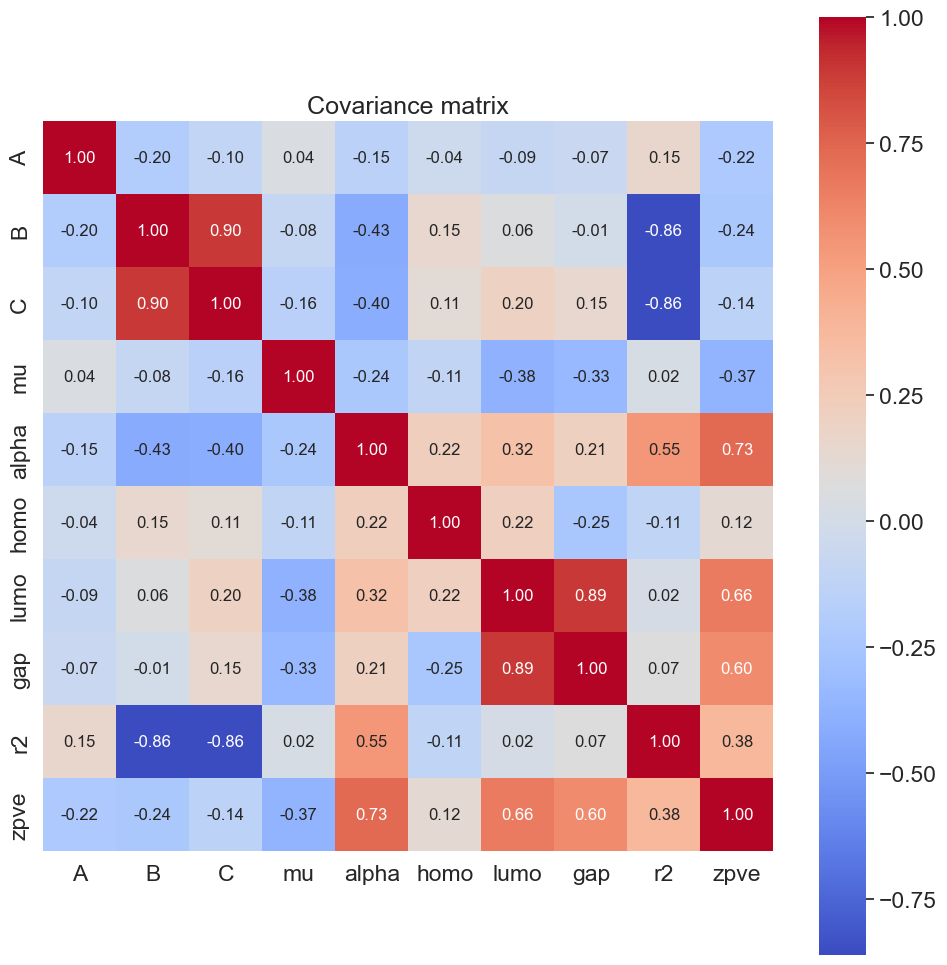

In [8]:
cols = features.columns[:10]

stdsc = StandardScaler()
X_std = stdsc.fit_transform(features[cols].iloc[:,range(10)].values)

cov_mat =np.cov(X_std.T)

plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12},
                 cmap='coolwarm',
                 yticklabels=cols,
                 xticklabels=cols)
plt.title('Covariance matrix', size = 18)
plt.tight_layout()
plt.show()

In [9]:
FILTER_THRESHOLD = 0.9

reduced_features = features.drop('gap', axis=1)
cols = reduced_features.columns
stdsc = StandardScaler()
X_std = stdsc.fit_transform(reduced_features[cols].iloc[:,range(reduced_features.shape[1])].values)

cov_mat =np.cov(X_std.T)

cov_mat_df = pd.DataFrame(cov_mat, columns=cols)

upper_tri = cov_mat_df.where(
    np.triu(
        np.ones(cov_mat_df.shape), k=1).astype(bool)
        )

to_drop = [column for column in upper_tri.columns if any(abs(upper_tri[column]) > FILTER_THRESHOLD)]
df_after_corr = res.drop(to_drop, axis=1)

In [10]:
df_after_corr

,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,JGI5,JGI8,JGI9,JGI10,JGT10,Diameter,Radius,TopoShapeIndex,SRW05,mZagreb2
0,gdb_119938,CN1C(CCO)C1C#N,2.53141,0.96859,0.85555,4.2807,76.97,-0.2483,0.0137,0.2621,...,0.018519,0.0,0.0,0.0,0.575856,6.0,3.0,1.000000,4.110874,2.250000
1,gdb_29238,Cc1c[nH]c(=O)[nH]c1=O,3.20844,1.40010,0.98060,4.0270,70.99,-0.2402,-0.0354,0.2048,...,0.000000,0.0,0.0,0.0,0.548472,5.0,3.0,0.666667,0.000000,2.027778
2,gdb_118356,CCOC(C=O)C1CN1,1.79964,1.28936,0.83151,2.8713,77.14,-0.2433,-0.0350,0.2082,...,0.026667,0.0,0.0,0.0,0.394026,5.0,3.0,0.666667,3.713572,2.277778
3,gdb_16321,COC12CC1OC2=N,3.25245,2.07265,1.45864,2.1158,62.84,-0.2572,0.0149,0.2721,...,0.000000,0.0,0.0,0.0,0.739484,4.0,2.0,1.000000,4.262680,1.750000
4,gdb_18556,O=C1CC2CCCC12,3.51722,1.96911,1.57502,2.8332,70.74,-0.2349,-0.0193,0.2156,...,0.000000,0.0,0.0,0.0,0.449705,4.0,2.0,1.000000,2.397895,1.722222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,gdb_51029,O=CCC1(CCO1)C#N,2.45710,1.24957,0.98290,5.5071,69.41,-0.2616,-0.0408,0.2208,...,0.031250,0.0,0.0,0.0,0.538287,5.0,3.0,0.666667,0.000000,2.250000
19996,gdb_43257,O=C1C=CC(=O)C11CN1,2.37695,2.03273,1.18845,2.3973,70.53,-0.2504,-0.0994,0.1509,...,0.000000,0.0,0.0,0.0,0.512696,4.0,2.0,1.000000,4.110874,1.916667
19997,gdb_69681,CC12OC1C1C(C#C)C21,3.16656,1.39029,1.24337,2.6071,78.66,-0.2237,0.0387,0.2624,...,0.031250,0.0,0.0,0.0,0.689812,5.0,3.0,0.666667,4.948760,1.819444
19998,gdb_114799,OCC1CC2OC=NC12,3.47548,1.21123,1.07822,0.3772,71.00,-0.2445,0.0169,0.2613,...,0.040000,0.0,0.0,0.0,0.437396,5.0,3.0,0.666667,2.397895,2.055556


In [ ]:
X = features.drop('gap', axis = 1)
y = features['gap']

estimator = RandomForestRegressor(n_jobs=-1)

sfs1 = sfs(estimator,
           n_features_to_select=250,
           scoring='r2',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X, y)
print(sfs1.support_)

In [12]:
df_after_corr.to_csv('Data/task2.csv', index = False)